### Detección de Anomalías en Credit Card Fraud Detection - UO286277 - Gustavo Sobrado Aller

Este notebook realiza un análisis detallado del dataset **Credit Card Fraud Detection** utilizando tres técnicas de detección de anomalías:
- **Z-score** (Estadístico)
- **DBSCAN** (Clustering)
- **Autoencoder** (Modelo avanzado de redes neuronales)
- **Ensambles** (Conjunto de varias técnicas)

El objetivo es comparar el desempeño de estas técnicas en la identificación de transacciones fraudulentas y evaluar su aplicabilidad en escenarios reales.

**Descripción:**

En esta celda se instalan (si no están disponibles) las librerías necesarias para el análisis y se importan todos los módulos requeridos. Incluye la configuración del entorno gráfico para mejorar la presentación de las figuras.

- `pip install`: para asegurar la disponibilidad de todas las librerías.
- `pandas`, `numpy`, `scikit-learn`: análisis y modelado.
- `matplotlib`, `seaborn`: visualización.
- `tensorflow`, `keras`: construcción del autoencoder.
- `imbalanced-learn`, `matplotlib-venn`: análisis de conjuntos y visualizaciones de tipo Venn.
- Configuración del estilo de graficado para uniformidad.


In [17]:
%pip install pandas numpy scikit-learn matplotlib seaborn tensorflow keras imbalanced-learn matplotlib-venn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, roc_auc_score, matthews_corrcoef, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from matplotlib_venn import venn3

# Configuraciones generales de visualización
sns.set_style('whitegrid')

Note: you may need to restart the kernel to use updated packages.


**Descripción:**

En esta celda se carga el dataset `creditcard.csv`, se muestran las primeras filas y se imprime información sobre el DataFrame, como el tipo de datos y si hay valores nulos. También se visualiza un resumen estadístico básico.

- Se verifica que el archivo `creditcard.csv` esté en el directorio de trabajo.
- `head()` para una vista rápida de las primeras filas.
- `info()` para conocer tipos de datos y cantidad de registros.
- `describe()` para estadísticas descriptivas iniciales.

In [38]:
# Cargar el dataset
dataset = pd.read_csv('creditcard.csv')
display(dataset.head())

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


**Descripción:**

Aquí se procede a:

- Normalizar las columnas `Amount` y `Time` utilizando `StandardScaler`.
- Reemplazar las columnas originales `Amount` y `Time` por las escaladas.
- Separar la variable objetivo (`Class`) del resto de las características.
- Dividir el conjunto de datos en entrenamiento y prueba, asegurando mantener la proporción de clases (fraudulento/no fraudulento) mediante `stratify`.

Finalmente, se imprimen los tamaños de los conjuntos resultantes.


Tamaño del conjunto de entrenamiento: (227845, 30)
Tamaño del conjunto de prueba: (56962, 30)

Transacciones normales: 284315
Transacciones fraudulentas: 492


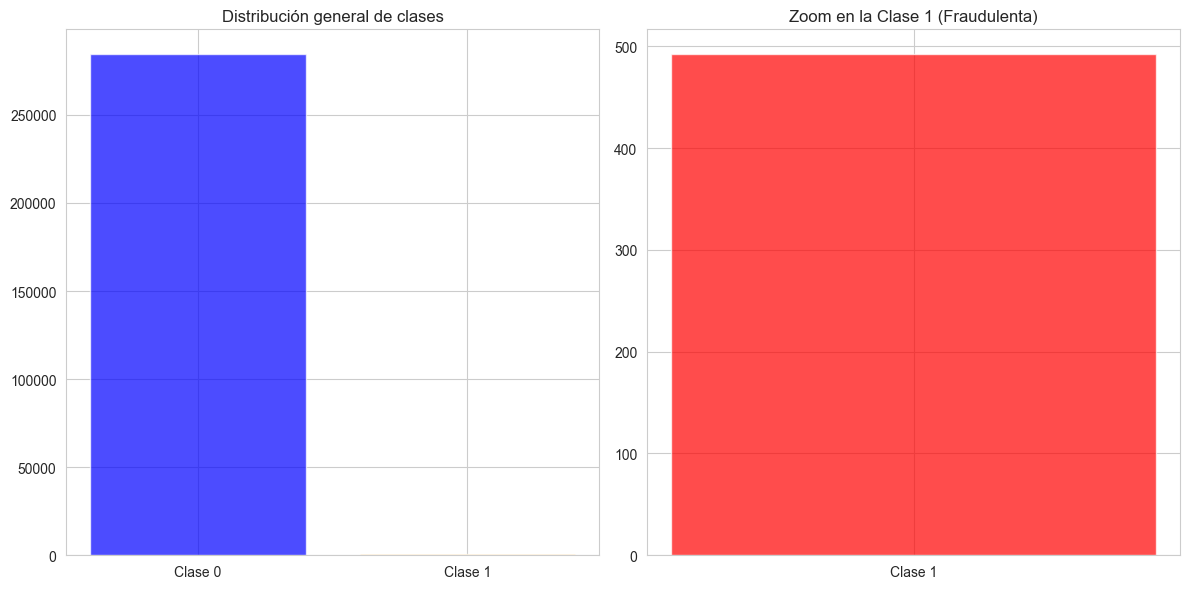

In [39]:
# Normalizar columnas 'Amount' y 'Time'
scaler = StandardScaler()
dataset['Amount_scaled'] = scaler.fit_transform(dataset[['Amount']])
dataset['Time_scaled'] = scaler.fit_transform(dataset[['Time']])
dataset.drop(columns=['Amount', 'Time'], inplace=True)

X = dataset.drop('Class', axis=1)
y = dataset['Class']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

print(f'Tamaño del conjunto de entrenamiento: {X_train.shape}')
print(f'Tamaño del conjunto de prueba: {X_test.shape}')

# Distribución de clases
class_counts = dataset['Class'].value_counts()
print(f"\nTransacciones normales: {class_counts[0]}")
print(f"Transacciones fraudulentas: {class_counts[1]}")

# Gráficos de distribución
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].bar(class_counts.index, class_counts.values, color=['blue', 'orange'], alpha=0.7)
axes[0].set_title('Distribución general de clases')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Clase 0', 'Clase 1'])

axes[1].bar([1], [class_counts[1]], color='red', alpha=0.7)
axes[1].set_title('Zoom en la Clase 1 (Fraudulenta)')
axes[1].set_xticks([1])
axes[1].set_xticklabels(['Clase 1'])

plt.tight_layout()
plt.show()


**Descripción:**

En esta celda se:

- Muestra la distribución de la clase (normal vs. fraudulenta).
- Crea un gráfico de barras para mostrar el desbalance de clases.
- Presenta un mapa de calor (heatmap) con las correlaciones entre variables.
- Muestra la distribución de `Amount_scaled` y `Time_scaled` por clase mediante diagramas de caja (boxplots).

Este análisis inicial ofrece una visión global del dataset, las variables y su relación con la clase.


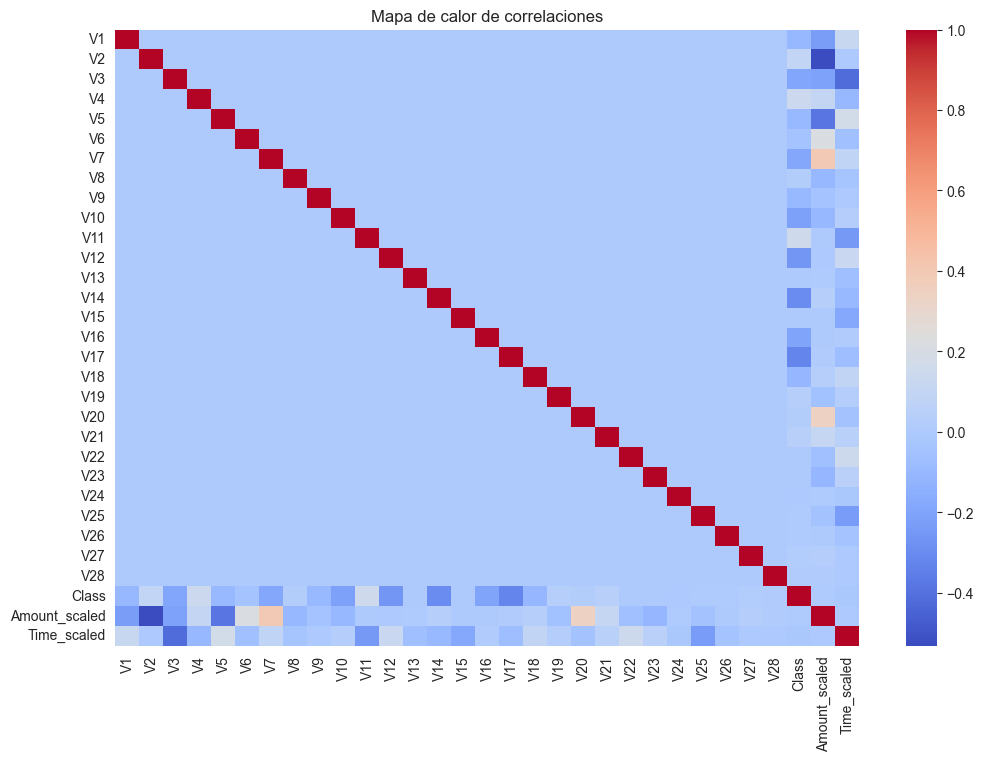

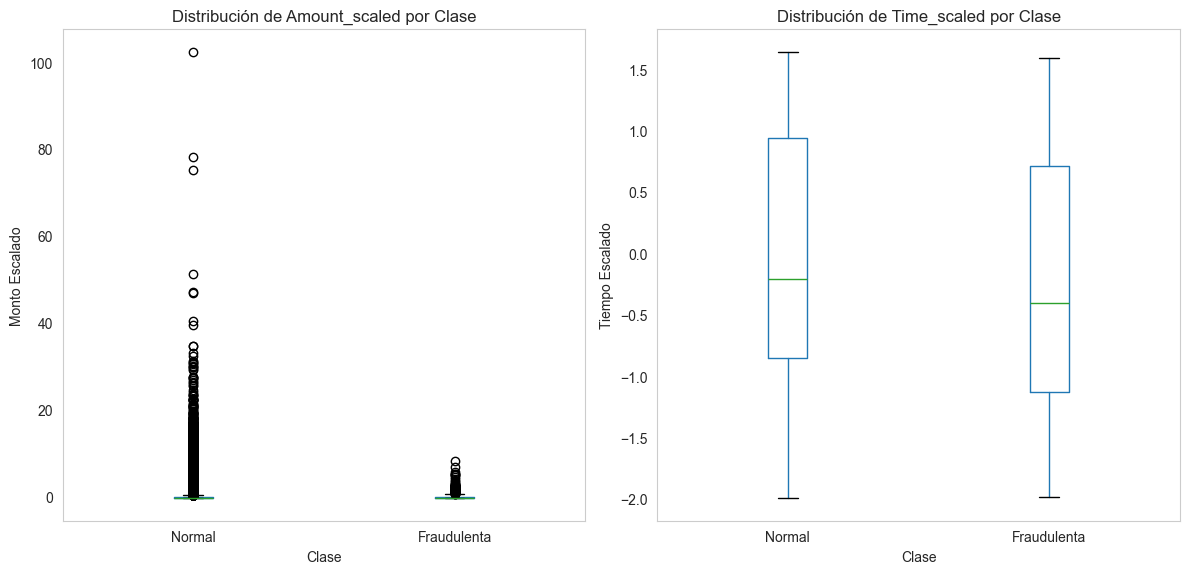

In [20]:
# Mapa de calor de correlaciones
correlation = dataset.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation, cmap='coolwarm')
plt.title('Mapa de calor de correlaciones')
plt.show()

# Distribución de Amount_scaled y Time_scaled por clase
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
dataset.boxplot(column=['Amount_scaled'], by='Class', grid=False, ax=axes[0])
axes[0].set_title('Distribución de Amount_scaled por Clase')
axes[0].set_xlabel('Clase')
axes[0].set_ylabel('Monto Escalado')
axes[0].set_xticklabels(['Normal', 'Fraudulenta'])

dataset.boxplot(column=['Time_scaled'], by='Class', grid=False, ax=axes[1])
axes[1].set_title('Distribución de Time_scaled por Clase')
axes[1].set_xlabel('Clase')
axes[1].set_ylabel('Tiempo Escalado')
axes[1].set_xticklabels(['Normal', 'Fraudulenta'])

plt.suptitle('')
plt.tight_layout()
plt.show()

**Descripción:**

En esta celda se utiliza el método estadístico Z-score para detectar puntos atípicos:

- Se calcula el Z-score de cada transacción respecto a la media y desviación estándar del conjunto de entrenamiento.
- Se define un umbral (2.5) para considerar un valor como anómalo.
- Se agrega una columna `ZscoreAnomaly` al conjunto de entrenamiento indicando si la transacción es potencialmente anómala según este criterio.

Al final se imprime el número de anomalías detectadas por Z-score.


In [21]:
z_scores = np.abs((X_train - X_train.mean()) / X_train.std())
threshold = 2.5
anomalies_zscore = (z_scores > threshold).any(axis=1)

X_train_with_clusters = X_train.copy()
X_train_with_clusters['ZscoreAnomaly'] = anomalies_zscore

print(f"Número de anomalías detectadas con Z-score: {anomalies_zscore.sum()}")

Número de anomalías detectadas con Z-score: 61777


**Descripción:**

Aquí se aplica el algoritmo de clustering DBSCAN:

- Se establece `eps=2` y `min_samples=15` como parámetros.
- DBSCAN encuentra grupos de alta densidad y clasifica puntos dispersos como outliers (anomalías).
- Se agrega `DBSCANCluster` al DataFrame y una columna booleana `DBSCANAnomaly` para indicar cuáles son considerados outliers por DBSCAN.

Al final se imprime el número de outliers detectados por DBSCAN.


In [22]:
dbscan = DBSCAN(eps=2, min_samples=15)
clusters_dbscan = dbscan.fit_predict(X_train)

X_train_with_clusters['DBSCANCluster'] = clusters_dbscan
X_train_with_clusters['DBSCANAnomaly'] = (clusters_dbscan == -1)

print(f"Número de outliers detectados por DBSCAN: {X_train_with_clusters['DBSCANAnomaly'].sum()}")

Número de outliers detectados por DBSCAN: 50298


**Descripción:**

Se implementa un autoencoder para la detección de anomalías:

- Se define y entrena una red neuronal autoencoder con varias capas densas.
- Una vez entrenado, se calculan los errores de reconstrucción para cada transacción.
- Se selecciona un percentil (85) del error de reconstrucción para establecer un umbral de anomalía.
- Se agrega la columna `AutoencoderAnomaly` al DataFrame.

Se imprime la cantidad de anomalías detectadas por el autoencoder.


In [23]:
input_dim = X_train.shape[1]
autoencoder = Sequential([
    Input(shape=(input_dim,)),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(16, activation='relu'),
    Dense(input_dim, activation='sigmoid')
])

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, X_train, epochs=20, batch_size=256, shuffle=True, validation_split=0.2, verbose=0)

reconstructions = autoencoder.predict(X_train)
reconstruction_errors = np.mean(np.power(X_train - reconstructions, 2), axis=1)

threshold_autoencoder = np.percentile(reconstruction_errors, 85)
X_train_with_clusters['AutoencoderAnomaly'] = reconstruction_errors > threshold_autoencoder

print(f"Número de anomalías detectadas por Autoencoder: {X_train_with_clusters['AutoencoderAnomaly'].sum()}")

7121/7121 ━━━━━━━━━━━━━━━━━━━━ 4s 544us/step
Número de anomalías detectadas por Autoencoder: 34177


**Descripción:**

En esta celda se aplica PCA (Análisis de Componentes Principales) a los datos de entrenamiento para reducir la dimensionalidad a 2 componentes, facilitando la visualización:

- Se crea un DataFrame con las dos primeras componentes principales (`PCA1` y `PCA2`).
- Se unen las columnas de anomalías detectadas por Z-score, DBSCAN y Autoencoder.
- Se agrega la clase real `Class`.

A continuación, se definen gráficos para visualizar, en el plano PCA, qué puntos fueron marcados como anómalos por cada método individual.


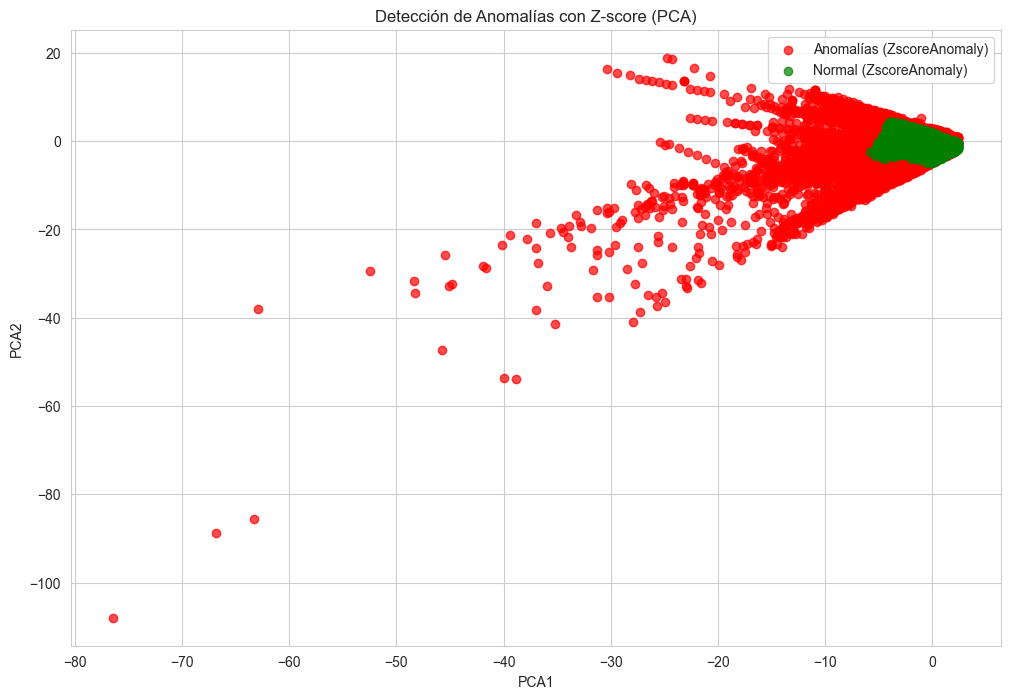

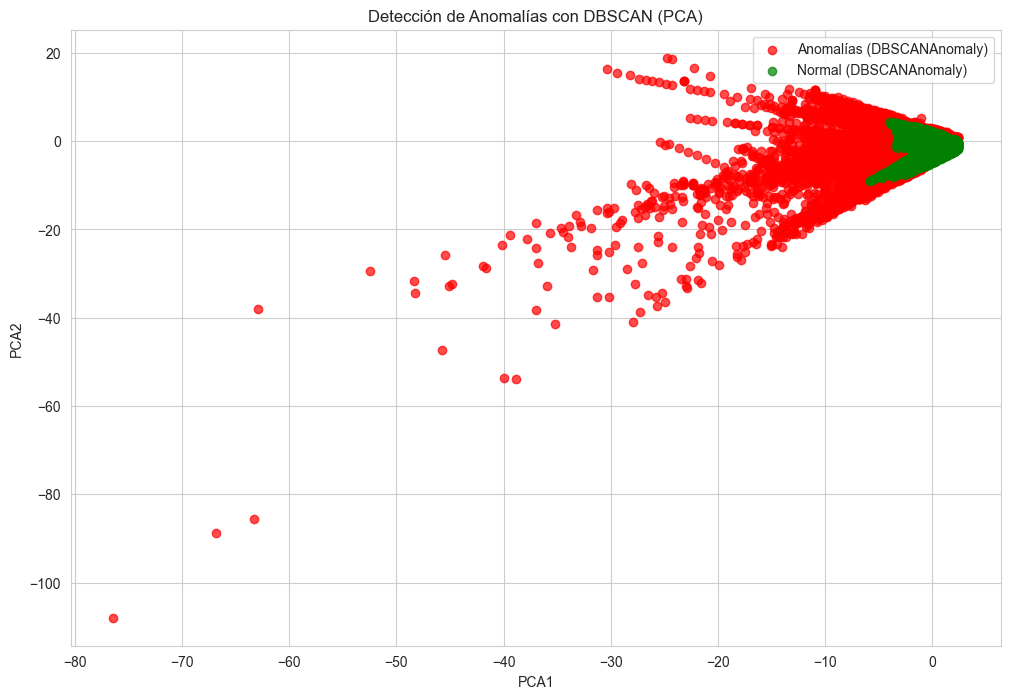

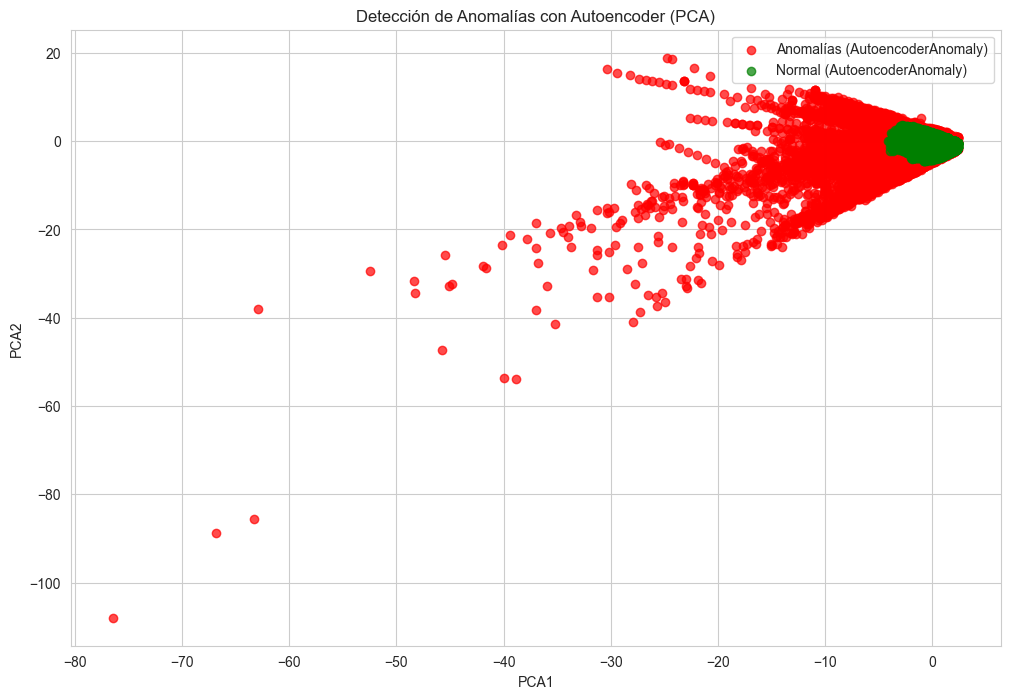

In [24]:
pca = PCA(n_components=2)
X_reduced_pca = pca.fit_transform(X_train)
X_reduced_df_pca = pd.DataFrame(X_reduced_pca, columns=['PCA1', 'PCA2'], index=X_train.index)
X_reduced_df_pca = X_reduced_df_pca.join(X_train_with_clusters[['ZscoreAnomaly', 'DBSCANAnomaly', 'AutoencoderAnomaly', 'DBSCANCluster']])
X_reduced_df_pca['Class'] = y_train

# Función auxiliar para graficar anomalías
def plot_anomalies(df, col, title):
    plt.figure(figsize=(12, 8))
    for anomaly in [True, False]:
        subset = df[df[col] == anomaly]
        label = f'Anomalías ({col})' if anomaly else f'Normal ({col})'
        color = 'red' if anomaly else 'green'
        plt.scatter(subset['PCA1'], subset['PCA2'], label=label, alpha=0.7, c=color)
    plt.title(title)
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.legend()
    plt.show()

plot_anomalies(X_reduced_df_pca, 'ZscoreAnomaly', 'Detección de Anomalías con Z-score (PCA)')
plot_anomalies(X_reduced_df_pca, 'DBSCANAnomaly', 'Detección de Anomalías con DBSCAN (PCA)')
plot_anomalies(X_reduced_df_pca, 'AutoencoderAnomaly', 'Detección de Anomalías con Autoencoder (PCA)')

**Descripción:**

Se definen los ensambles:

- `EnsambleAnomaly2`: marca una transacción como anómala si al menos 2 de los 3 métodos la detectan.
- `EnsambleAnomaly3`: marca una transacción como anómala sólo si los 3 métodos coinciden en considerarla anómala.

Esta lógica combina las fortalezas de cada método individual.


In [25]:
X_train_with_clusters['EnsambleAnomaly2'] = (X_train_with_clusters[['ZscoreAnomaly', 'DBSCANAnomaly']].sum(axis=1) >= 2)
X_train_with_clusters['EnsambleAnomaly3'] = X_train_with_clusters[['ZscoreAnomaly', 'DBSCANAnomaly', 'AutoencoderAnomaly']].all(axis=1)

**Descripción:**

Se aplica PCA de nuevo a los datos originales para visualizar los ensambles:

- Se construye un DataFrame reducido a 2 componentes principales (`PCA1`, `PCA2`).
- Se agregan las columnas de `EnsambleAnomaly2` y `EnsambleAnomaly3`.
- Se grafican las anomalías detectadas por cada ensamble (2 métodos y 3 métodos) en el espacio PCA.

De esta forma, es posible apreciar espacialmente cómo se distribuyen las anomalías detectadas por las estrategias de ensamble.


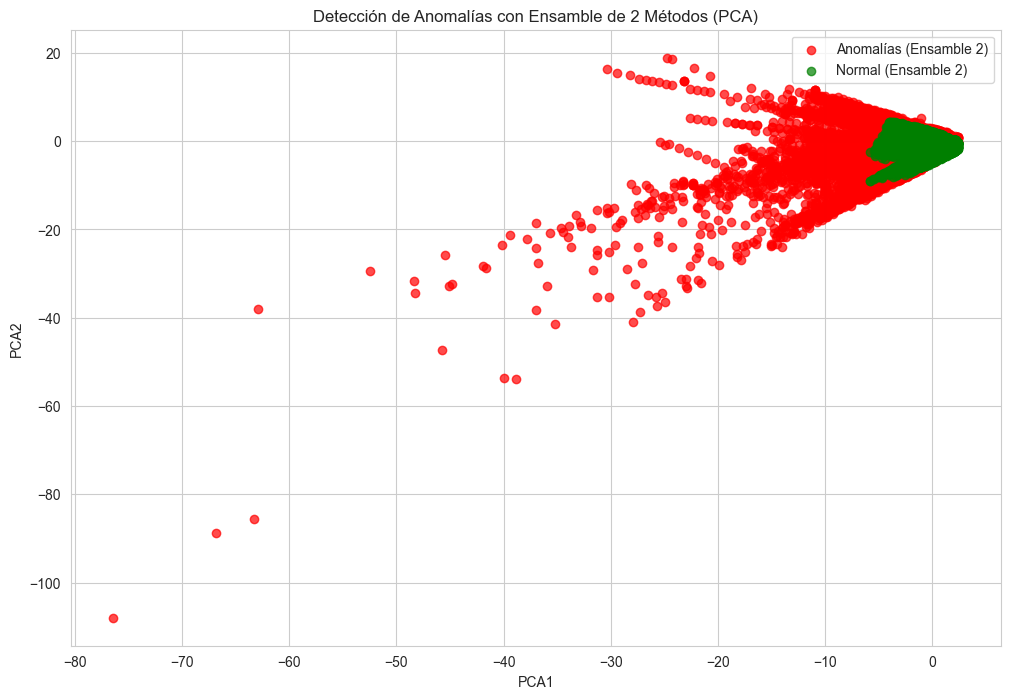

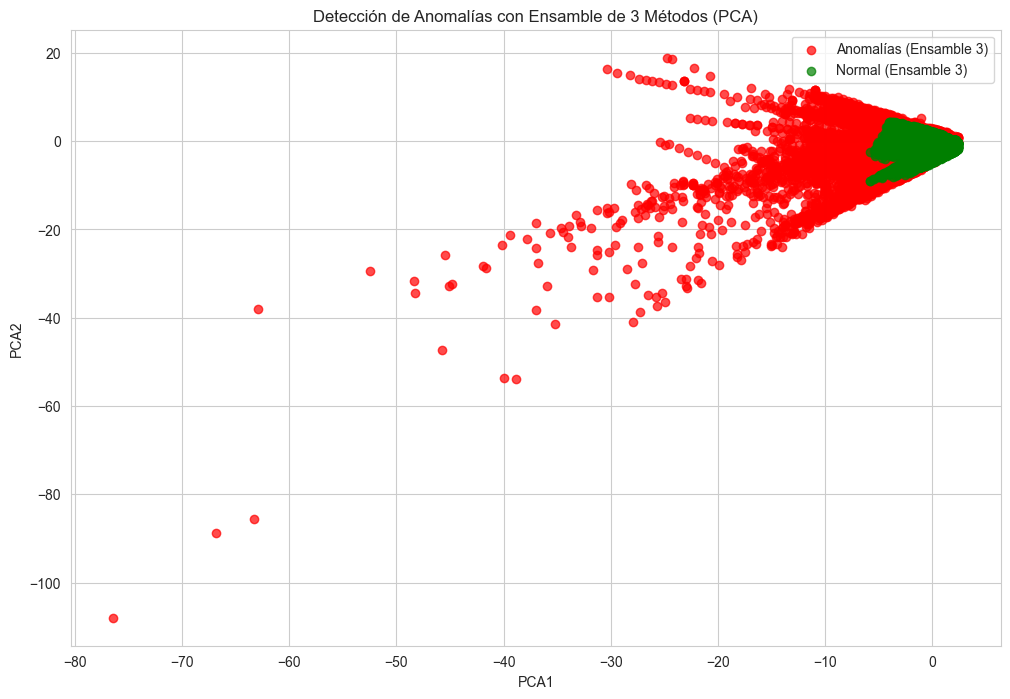

In [26]:
pca_ensamble = PCA(n_components=2)
X_reduced_ensamble = pca_ensamble.fit_transform(X_train)
X_reduced_df_ensamble = pd.DataFrame(X_reduced_ensamble, columns=['PCA1', 'PCA2'], index=X_train.index)
X_reduced_df_ensamble['EnsambleAnomaly2'] = X_train_with_clusters['EnsambleAnomaly2']
X_reduced_df_ensamble['EnsambleAnomaly3'] = X_train_with_clusters['EnsambleAnomaly3']

# Graficar Ensamble (=2)
plt.figure(figsize=(12, 8))
for anomaly in [True, False]:
    anomaly_data = X_reduced_df_ensamble[X_reduced_df_ensamble['EnsambleAnomaly2'] == anomaly]
    label = 'Anomalías (Ensamble 2)' if anomaly else 'Normal (Ensamble 2)'
    color = 'red' if anomaly else 'green'
    plt.scatter(anomaly_data['PCA1'], anomaly_data['PCA2'], label=label, alpha=0.7, c=color)
plt.title('Detección de Anomalías con Ensamble de 2 Métodos (PCA)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

# Graficar Ensamble (=3)
plt.figure(figsize=(12, 8))
for anomaly in [True, False]:
    anomaly_data = X_reduced_df_ensamble[X_reduced_df_ensamble['EnsambleAnomaly3'] == anomaly]
    label = 'Anomalías (Ensamble 3)' if anomaly else 'Normal (Ensamble 3)'
    color = 'red' if anomaly else 'green'
    plt.scatter(anomaly_data['PCA1'], anomaly_data['PCA2'], label=label, alpha=0.7, c=color)
plt.title('Detección de Anomalías con Ensamble de 3 Métodos (PCA)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

**Descripción:**

Se toma el ensamble (=2), es decir, anomalías detectadas por al menos 2 métodos.

- Se clasifica cada punto como True Positive, False Positive, True Negative o False Negative comparando `DetectedAnomaly` con la clase real `Class`.
- Se grafica en el plano PCA el resultado (TP, FP, TN, FN).
- Se calcula la matriz de confusión para el ensamble (=2) y se muestran las tasas de falsos positivos y falsos negativos.

Esto permite evaluar el rendimiento del ensamble con criterios cuantitativos.


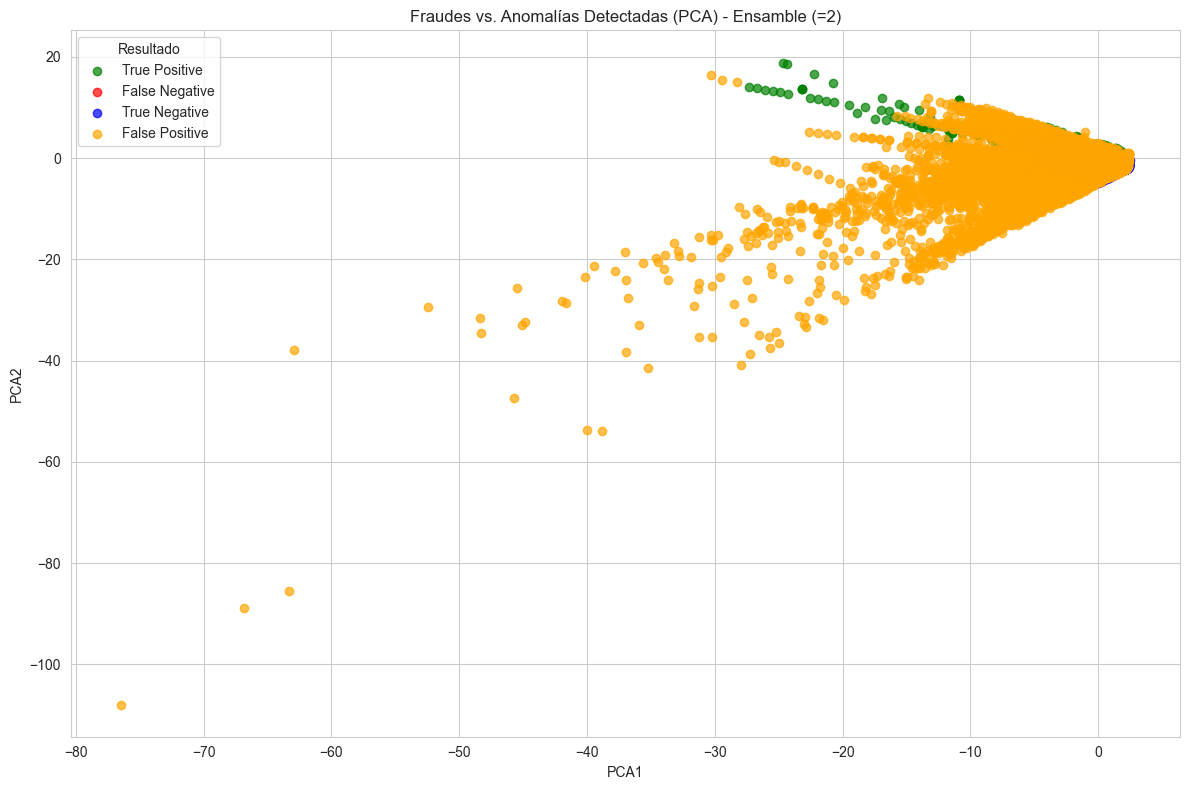

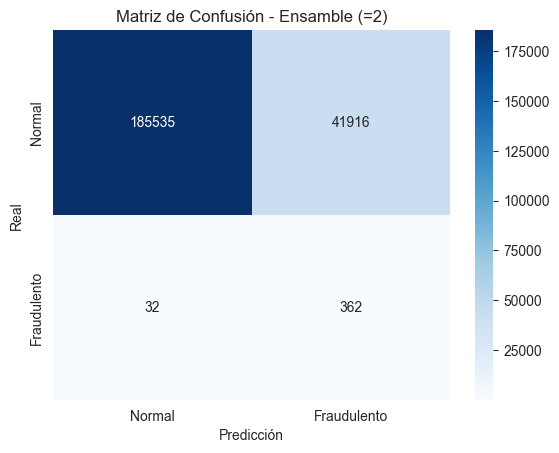

Ensamble (=2)
TN: 185535, FP: 41916, FN: 32, TP: 362
Porcentaje de Falsos Positivos: 18.43%
Porcentaje de Falsos Negativos: 8.12%


In [27]:
X_reduced_df_pca['DetectedAnomaly'] = (X_reduced_df_pca[['ZscoreAnomaly', 'DBSCANAnomaly', 'AutoencoderAnomaly']].sum(axis=1) >= 2)
X_reduced_df_pca['Result'] = 'True Negative'
X_reduced_df_pca.loc[(X_reduced_df_pca['Class'] == 1) & (X_reduced_df_pca['DetectedAnomaly'] == True), 'Result'] = 'True Positive'
X_reduced_df_pca.loc[(X_reduced_df_pca['Class'] == 1) & (X_reduced_df_pca['DetectedAnomaly'] == False), 'Result'] = 'False Negative'
X_reduced_df_pca.loc[(X_reduced_df_pca['Class'] == 0) & (X_reduced_df_pca['DetectedAnomaly'] == True), 'Result'] = 'False Positive'

plt.figure(figsize=(12, 8))
colors = {'True Positive': 'green', 'False Negative': 'red', 'True Negative': 'blue', 'False Positive': 'orange'}
for result_type, color in colors.items():
    subset = X_reduced_df_pca[X_reduced_df_pca['Result'] == result_type]
    plt.scatter(subset['PCA1'], subset['PCA2'], label=result_type, alpha=0.7, c=color)
plt.title('Fraudes vs. Anomalías Detectadas (PCA) - Ensamble (=2)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title="Resultado", fontsize=10)
plt.tight_layout()
plt.show()

y_pred_2 = X_reduced_df_pca['DetectedAnomaly'].astype(int)
cm_2 = confusion_matrix(y_train, y_pred_2)
sns.heatmap(cm_2, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraudulento'], yticklabels=['Normal', 'Fraudulento'])
plt.title('Matriz de Confusión - Ensamble (=2)')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

TN, FP, FN, TP = cm_2.ravel()
print("Ensamble (=2)")
print(f'TN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}')
print(f"Porcentaje de Falsos Positivos: {FP / (FP + TN) * 100:.2f}%")
print(f"Porcentaje de Falsos Negativos: {FN / (FN + TP) * 100:.2f}%")

**Descripción:**

Se repite el proceso anterior para el ensamble (=3), es decir, anomalías detectadas por los 3 métodos a la vez.

- Se asignan TP, FP, TN, FN según `DetectedAnomaly` y la clase real.
- Se grafica la distribución en el plano PCA.
- Se calcula la matriz de confusión y las tasas de error (FP y FN).

Así se compara el comportamiento del ensamble más estricto con el anterior.


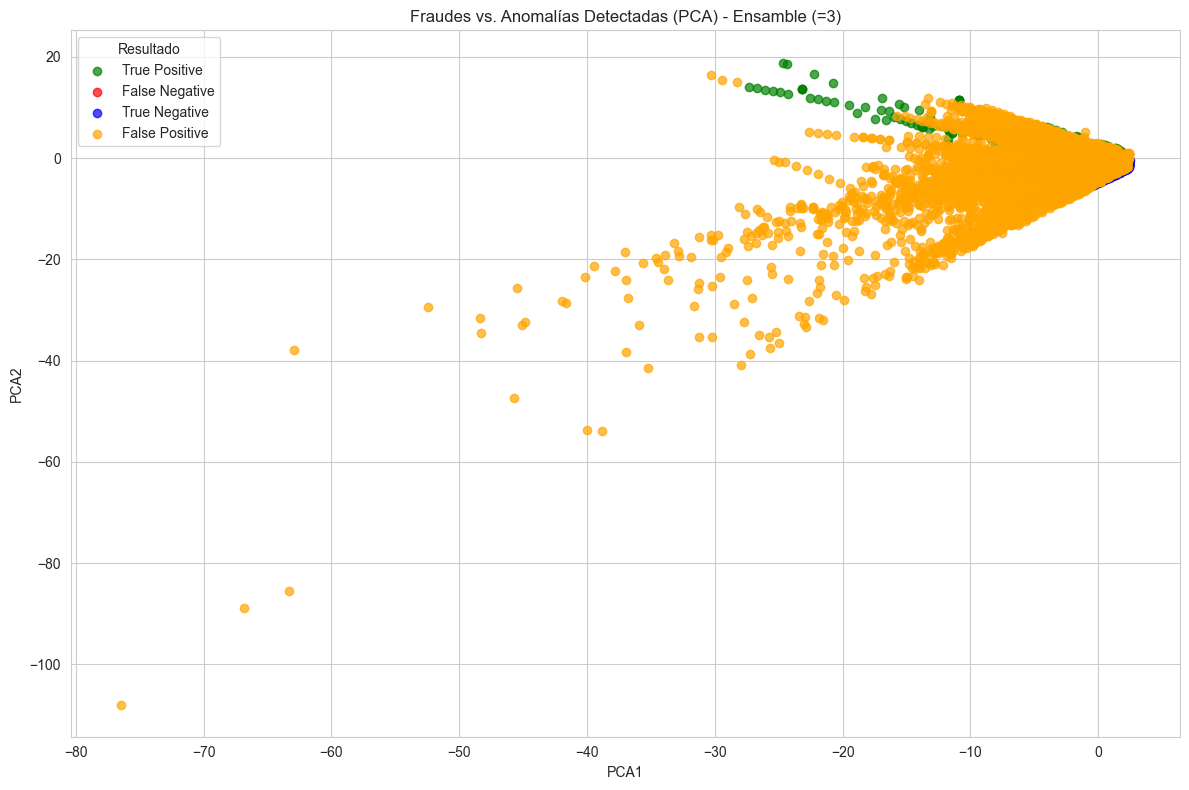

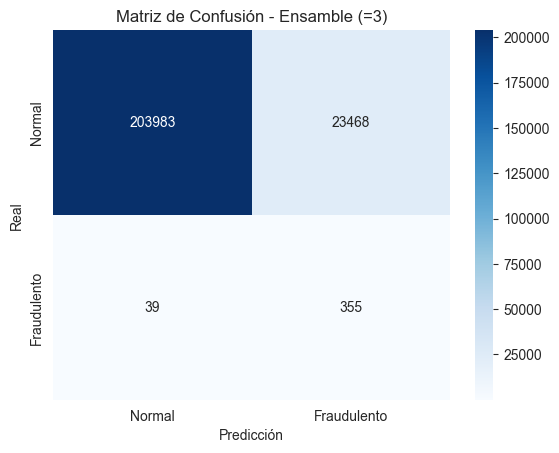

Ensamble (=3)
TN: 203983, FP: 23468, FN: 39, TP: 355
Porcentaje de Falsos Positivos: 10.32%
Porcentaje de Falsos Negativos: 9.90%


In [28]:
X_reduced_df_pca['DetectedAnomaly'] = (X_reduced_df_pca[['ZscoreAnomaly', 'DBSCANAnomaly', 'AutoencoderAnomaly']].sum(axis=1) == 3)
X_reduced_df_pca['Result'] = 'True Negative'
X_reduced_df_pca.loc[(X_reduced_df_pca['Class'] == 1) & (X_reduced_df_pca['DetectedAnomaly'] == True), 'Result'] = 'True Positive'
X_reduced_df_pca.loc[(X_reduced_df_pca['Class'] == 1) & (X_reduced_df_pca['DetectedAnomaly'] == False), 'Result'] = 'False Negative'
X_reduced_df_pca.loc[(X_reduced_df_pca['Class'] == 0) & (X_reduced_df_pca['DetectedAnomaly'] == True), 'Result'] = 'False Positive'

plt.figure(figsize=(12, 8))
for result_type, color in colors.items():
    subset = X_reduced_df_pca[X_reduced_df_pca['Result'] == result_type]
    plt.scatter(subset['PCA1'], subset['PCA2'], label=result_type, alpha=0.7, c=color)
plt.title('Fraudes vs. Anomalías Detectadas (PCA) - Ensamble (=3)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title="Resultado", fontsize=10)
plt.tight_layout()
plt.show()

y_pred_3 = X_reduced_df_pca['DetectedAnomaly'].astype(int)
cm_3 = confusion_matrix(y_train, y_pred_3)
sns.heatmap(cm_3, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Fraudulento'], yticklabels=['Normal', 'Fraudulento'])
plt.title('Matriz de Confusión - Ensamble (=3)')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

TN, FP, FN, TP = cm_3.ravel()
print("Ensamble (=3)")
print(f'TN: {TN}, FP: {FP}, FN: {FN}, TP: {TP}')
print(f"Porcentaje de Falsos Positivos: {FP / (FP + TN) * 100:.2f}%")
print(f"Porcentaje de Falsos Negativos: {FN / (FN + TP) * 100:.2f}%")

**Descripción:**

En esta celda se:

- Construye un diagrama de Venn para visualizar las intersecciones entre las anomalías detectadas por Z-score, DBSCAN y Autoencoder.
- Se muestra la cantidad total de anomalías detectadas por cada método.
- Este análisis visual facilita la comprensión de la superposición y diferencia entre los métodos individuales.


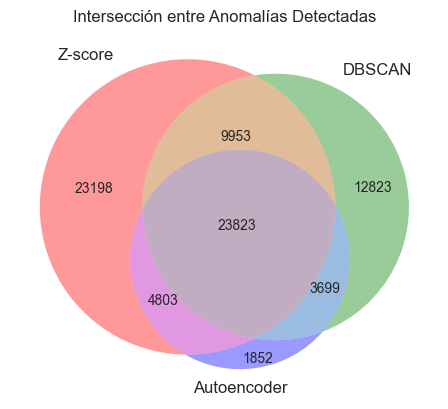

Comparación de detecciones entre métodos:
ZscoreAnomaly         61777
DBSCANAnomaly         50298
AutoencoderAnomaly    34177
dtype: int64


In [35]:
zscore_anomalies = set(X_train_with_clusters[X_train_with_clusters['ZscoreAnomaly']].index)
dbscan_anomalies = set(X_train_with_clusters[X_train_with_clusters['DBSCANAnomaly']].index)
autoencoder_anomalies = set(X_train_with_clusters[X_train_with_clusters['AutoencoderAnomaly']].index)

venn3([zscore_anomalies, dbscan_anomalies, autoencoder_anomalies], set_labels=('Z-score', 'DBSCAN', 'Autoencoder'))
plt.title("Intersección entre Anomalías Detectadas")
plt.show()

comparison = X_train_with_clusters[['ZscoreAnomaly', 'DBSCANAnomaly', 'AutoencoderAnomaly']]
print("Comparación de detecciones entre métodos:")
print(comparison.sum())

**Descripción:**

En esta celda se calcula el número de fraudes detectados por cada método individual (Z-score, DBSCAN, Autoencoder) y por los ensambles definidos (al menos 2 métodos, los 3 métodos). Estos cálculos permiten evaluar la eficacia de cada enfoque en la identificación de fraudes en el conjunto de datos.

   - Número de fraudes detectados por cada método (Z-score, DBSCAN, Autoencoder).
   - Número de fraudes detectados por cada ensamble.
   - Los resultados se imprimen directamente, proporcionando un resumen de la efectividad de los métodos y combinaciones.


In [55]:
# Definir los métodos y sus nombres descriptivos
methods = {
    'ZscoreAnomaly': 'Z-score',
    'DBSCANAnomaly': 'DBSCAN',
    'AutoencoderAnomaly': 'Autoencoder',
    'EnsambleAnomaly2': 'Ensamble (>=2)',
    'EnsambleAnomaly3': 'Ensamble (=3)'
}

# Calcular fraudes detectados por cada método y ensamble
frauds_detected = {name: y_train[X_train_with_clusters[col]].sum() for col, name in methods.items()}

# Imprimir los resultados con nombres descriptivos
for name, count in frauds_detected.items():
    print(f"Fraudes detectados por {name}: {count}")

Fraudes detectados por Z-score: 363
Fraudes detectados por DBSCAN: 372
Fraudes detectados por Autoencoder: 357
Fraudes detectados por Ensamble (>=2): 362
Fraudes detectados por Ensamble (=3): 355


**Descripción:**

Se calculan métricas adicionales para evaluar el rendimiento de cada método y los ensambles:

- `AUC-ROC`: área bajo la curva ROC, mide capacidad discriminativa.
- `MCC` (Matthews Correlation Coefficient): coeficiente que mide la calidad de las predicciones.
- `classification_report`: métricas de precisión, recall y F1-score para la clase fraude.

Se construye una tabla `results_table` con estas métricas para cada método, permitiendo una comparación más integral.


In [44]:
y_pred_zscore = X_train_with_clusters['ZscoreAnomaly'].astype(int)
y_pred_dbscan = X_train_with_clusters['DBSCANAnomaly'].astype(int)
y_pred_autoencoder = X_train_with_clusters['AutoencoderAnomaly'].astype(int)

y_pred_ensamble_2 = X_train_with_clusters[['ZscoreAnomaly', 'DBSCANAnomaly']].sum(axis=1) >= 2
y_pred_ensamble_3 = X_train_with_clusters[['ZscoreAnomaly', 'DBSCANAnomaly', 'AutoencoderAnomaly']].all(axis=1)

# AUC-ROC
auc_zscore = roc_auc_score(y_train, y_pred_zscore)
auc_dbscan = roc_auc_score(y_train, y_pred_dbscan)
auc_autoencoder = roc_auc_score(y_train, y_pred_autoencoder)
auc_ensamble_2 = roc_auc_score(y_train, y_pred_ensamble_2)
auc_ensamble_3 = roc_auc_score(y_train, y_pred_ensamble_3.astype(int))

# MCC
mcc_zscore = matthews_corrcoef(y_train, y_pred_zscore)
mcc_dbscan = matthews_corrcoef(y_train, y_pred_dbscan)
mcc_autoencoder = matthews_corrcoef(y_train, y_pred_autoencoder)
mcc_ensamble_2 = matthews_corrcoef(y_train, y_pred_ensamble_2)
mcc_ensamble_3 = matthews_corrcoef(y_train, y_pred_ensamble_3.astype(int))

# Reportes de clasificación
methods_dict = {
    'Z-score': y_pred_zscore,
    'DBSCAN': y_pred_dbscan,
    'Autoencoder': y_pred_autoencoder,
    'Ensamble (>=2)': y_pred_ensamble_2.astype(int),
    'Ensamble (=3)': y_pred_ensamble_3.astype(int)
}

reports = {}
auc_values = {'Z-score': auc_zscore, 'DBSCAN': auc_dbscan, 'Autoencoder': auc_autoencoder, 'Ensamble (>=2)': auc_ensamble_2, 'Ensamble (=3)': auc_ensamble_3}
mcc_values = {'Z-score': mcc_zscore, 'DBSCAN': mcc_dbscan, 'Autoencoder': mcc_autoencoder, 'Ensamble (>=2)': mcc_ensamble_2, 'Ensamble (=3)': mcc_ensamble_3}

for method, preds in methods_dict.items():
    rep = classification_report(y_train, preds, output_dict=True)
    reports[method] = {
        'Método': method,
        'Precisión (Fraude)': rep['1']['precision'],
        'Recall (Fraude)': rep['1']['recall'],
        'F1-Score (Fraude)': rep['1']['f1-score'],
        'Precisión Global': rep['accuracy'],
        'AUC-ROC': auc_values[method],
        'MCC': mcc_values[method]
    }

results_table = pd.DataFrame.from_dict(reports, orient='index')
print(results_table)

                        Método  Precisión (Fraude)  Recall (Fraude)  \
Z-score                Z-score            0.005876         0.921320   
DBSCAN                  DBSCAN            0.007396         0.944162   
Autoencoder        Autoencoder            0.010446         0.906091   
Ensamble (>=2)  Ensamble (>=2)            0.010658         0.913706   
Ensamble (=3)    Ensamble (=3)            0.014902         0.901015   

                F1-Score (Fraude)  Precisión Global   AUC-ROC       MCC  
Z-score                  0.011677          0.730321  0.825655  0.060873  
DBSCAN                   0.014677          0.780781  0.862330  0.072593  
Autoencoder              0.020653          0.851403  0.878700  0.088130  
Ensamble (>=2)           0.021071          0.853190  0.883395  0.089657  
Ensamble (=3)            0.029318          0.896829  0.898918  0.108335  


**Descripción:**

Finalmente, se presentan visualizaciones que comparan las principales métricas entre los distintos métodos y ensambles:

- Gráfico de barras para Precisión (Fraude), Recall (Fraude), F1-Score (Fraude).
- Gráfico de barras horizontales para Precisión Global.
- Gráfico de barras para AUC-ROC.
- Gráfico de barras para MCC.

Estos gráficos ayudan a entender rápidamente el rendimiento relativo de cada enfoque y cuál ofrece el mejor balance entre las distintas métricas evaluadas.


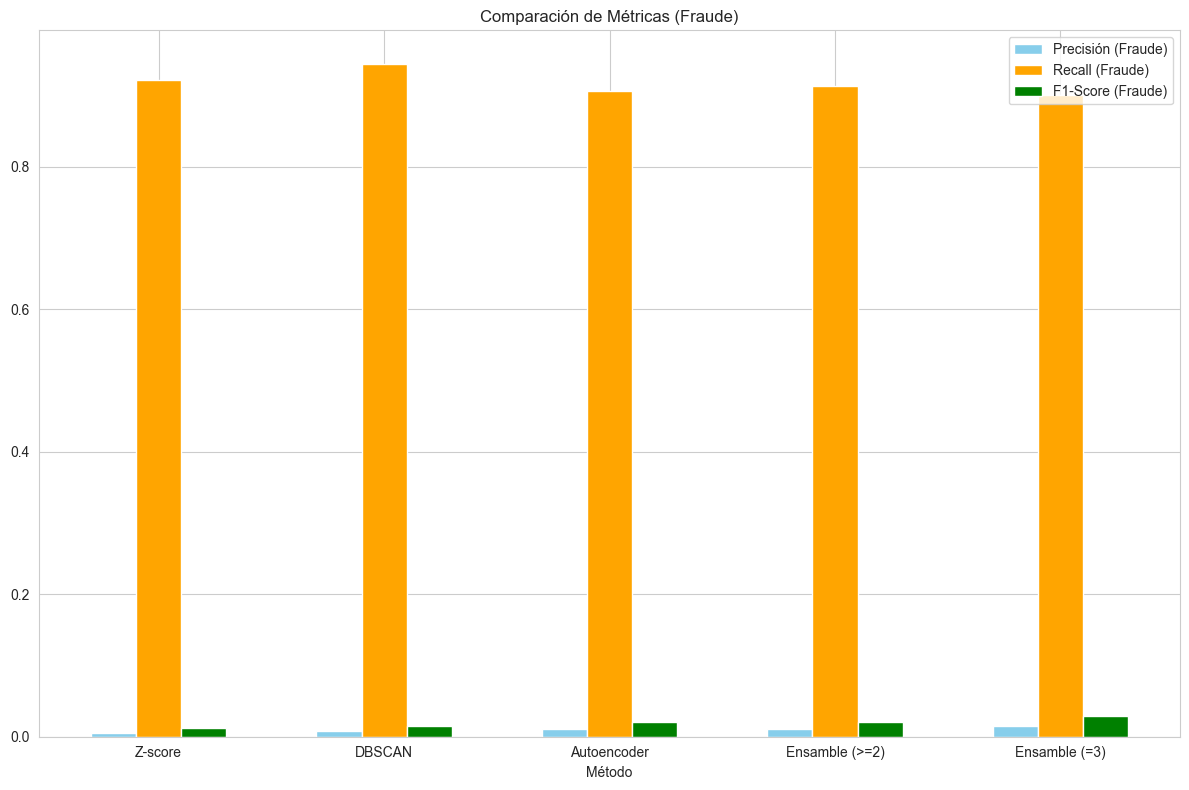

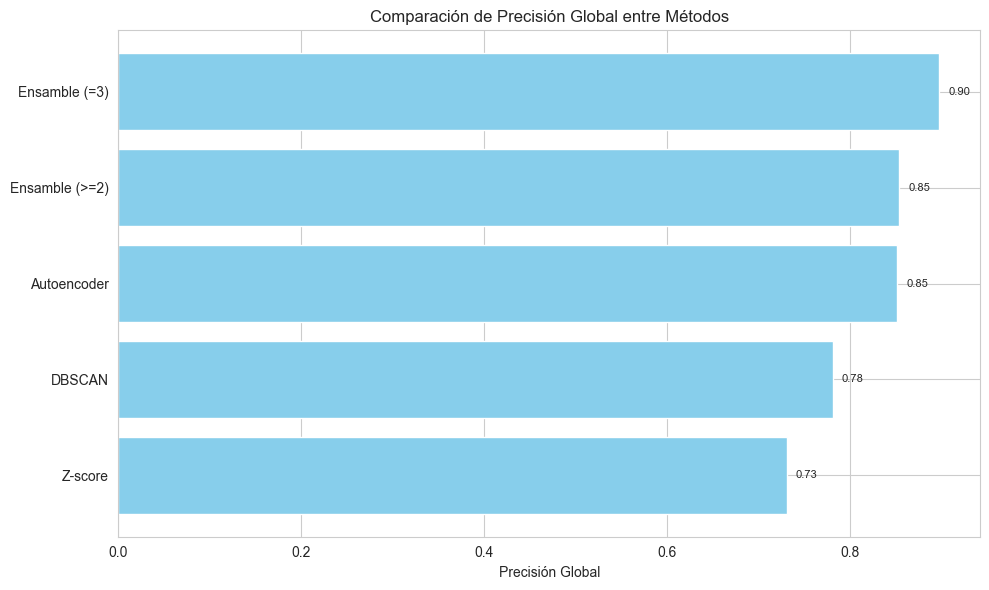

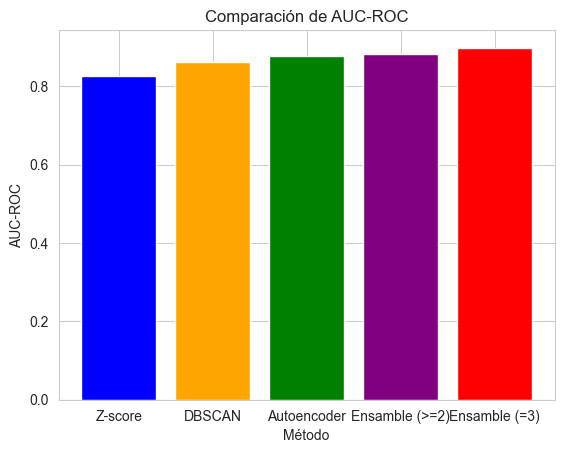

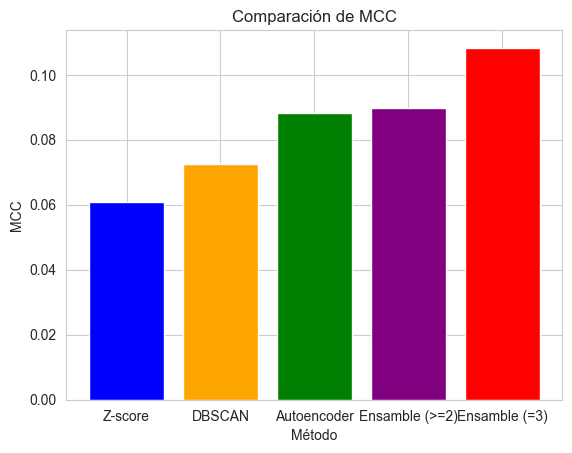

In [45]:
methods = results_table['Método']
f1_scores = results_table['F1-Score (Fraude)']
precision_fraud = results_table['Precisión (Fraude)']
recall_fraud = results_table['Recall (Fraude)']
global_precision = results_table['Precisión Global']
auc_scores = results_table['AUC-ROC']
mcc_scores = results_table['MCC']

# Gráfico comparativo de precisión, recall y F1 para fraude
fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.2
index = np.arange(len(methods))

ax.bar(index, precision_fraud, bar_width, label='Precisión (Fraude)', color='skyblue')
ax.bar(index + bar_width, recall_fraud, bar_width, label='Recall (Fraude)', color='orange')
ax.bar(index + 2 * bar_width, f1_scores, bar_width, label='F1-Score (Fraude)', color='green')
ax.set_xlabel('Método')
ax.set_title('Comparación de Métricas (Fraude)')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(methods)
ax.legend()
plt.tight_layout()
plt.show()

# Gráfico de precisión global
plt.figure(figsize=(10, 6))
bars = plt.barh(methods, global_precision, color='skyblue')
plt.xlabel('Precisión Global')
plt.title('Comparación de Precisión Global entre Métodos')
for bar in bars:
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.2f}', va='center', ha='left', fontsize=8)
plt.tight_layout()
plt.show()

# Gráfico AUC-ROC
plt.bar(methods, auc_scores, color=['blue', 'orange', 'green', 'purple', 'red'])
plt.xlabel('Método')
plt.ylabel('AUC-ROC')
plt.title('Comparación de AUC-ROC')
plt.show()

# Gráfico MCC
plt.bar(methods, mcc_scores, color=['blue', 'orange', 'green', 'purple', 'red'])
plt.xlabel('Método')
plt.ylabel('MCC')
plt.title('Comparación de MCC')
plt.show()